In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Data_handler import get_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 3 Betting Against Beta

## Question a)

In [135]:
# Prepare data
data = get_data()
Data = data.copy()

In [4]:
# Only keep permnos having more than 36 months of data
print("Original number of rows: ", Data.shape[0])
Data = Data.groupby('permno').filter(lambda permno: len(permno) >= 36)
print("Terminal number of rows: ", Data.shape[0])

display(Data.head())

Original number of rows:  1439408
Terminal number of rows:  1402358


,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746


In [5]:
# Compute time varying beta for each stock
Data["date"] = pd.to_datetime(Data["date"], format = "%Y-%m-%d") # set date in the correct format

Data["Rm_e"] = Data["vwretd"] - Data["tmytm"]
Data["R_e"]  = Data["ret"] - Data["tmytm"]

# From PS_5_solution
cov_nm = Data.set_index('date').groupby('permno')[['R_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)

# Data_beta = pd.merge(Data, beta_n, on=['date','permno'], how='left')
# display(Data_beta)

Data_beta = pd.merge(
    left = Data,
    right = beta_n,
    on = ["date", "permno"],
    how = "left"
)

# Winsorize at 95%
Data_beta['beta'] = Data_beta['beta'].clip(Data_beta['beta'].quantile(0.05), Data_beta['beta'].quantile(0.95))

In [104]:
display(Data_beta.tail(5))

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
1402353,92655,2004-10-29,-0.018172,664698.0,72.40,6324,0.001458,0.017806,0.016348,-0.019630,NaN
1402354,92655,2004-09-30,0.115076,664698.0,73.74,6324,0.001216,0.020556,0.019340,0.113860,0.926645
1402355,92655,2004-08-31,0.051351,664698.0,66.13,6324,0.001201,0.002703,0.001502,0.050150,NaN
1402356,92655,2004-07-30,0.010442,664098.0,62.90,6324,0.001066,-0.037698,-0.038764,0.009376,0.969307
1402357,92655,2004-06-30,-0.045977,615824.0,62.25,6324,0.000941,0.021611,0.020670,-0.046918,NaN


## Question b)

In [8]:
data_Qb = Data_beta.copy().dropna()
print(Data_beta.shape)
print(data_Qb.shape)

(1402358, 11)
(412246, 11)


In [12]:
# Create deciles based on Beta value
data_Qb["monthly_decile"] = data_Qb.groupby("date")["beta"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute monthly return per decile group
data_Qb["monthly_return"] = data_Qb.groupby(["date", "monthly_decile"])["ret"].transform("mean")

display(data_Qb.sample(5)) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,monthly_decile,monthly_return
1174612,78001,2015-08-31,-0.115880,45777.0,2.0600,3674,-0.000006,-0.059926,-0.059920,-0.115874,0.419608,0,-0.040758
1012177,63749,1990-08-31,0.028302,1980.0,-6.8125,1311,0.006260,-0.091903,-0.098163,0.022042,0.419608,0,-0.168984
1291762,85965,1993-07-30,0.048649,21396.0,24.2500,3312,0.002406,-0.000806,-0.003212,0.046243,1.345346,6,0.011689
155957,17291,1980-04-30,0.012987,26116.0,29.2500,5411,0.007728,0.052287,0.044559,0.005259,1.477603,7,0.029923
604116,40854,1977-09-30,0.015349,6602.0,27.1250,4832,0.004858,0.001572,-0.003286,0.010491,1.534070,8,0.001865


In [54]:
# Plot the value-weighted decile portfolios

# Add company market capitalization
data_Qb['MktCap'] = np.abs(data_Qb.prc) * data_Qb.shrout

# Create monthly deciles based MktCap
data_Qb["MktCap_decile"] = data_Qb.groupby("date")["MktCap"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute monthly return per decile group
data_Qb["monthly_return_MktCap"] = data_Qb.groupby(["date", "MktCap_decile"])["ret"].transform("mean")

display(data_Qb.head(5)) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,monthly_decile,monthly_return,MktCap,MktCap_decile,monthly_return_MktCap
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358,3,0.040807,6607.1250,0,-0.057235
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659,4,0.003701,8089.1250,0,0.029639
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189,4,0.040760,9192.1875,0,0.033312
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094,4,0.044687,10938.7500,0,0.009590
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478,5,0.017687,13126.5000,0,0.019988


In [152]:
def plot_return_std_SR_deciles(data, decile_col_name, decile_return_col_name, plot_name, question):

    # Plot average annualized portfolio mean, std, sharpe ratio
    deciles = list(data[decile_col_name].unique())
    deciles.sort()

    MEAN, STD, SR = [], [], []

    for decile in deciles:
        d = data[data[decile_col_name] == decile]#.head(2)
        rf = d["tmytm"].mean() * 12
        mean = d[decile_return_col_name].mean() * 12
        std = d[decile_return_col_name].std() * np.sqrt(12)
        sr = (mean - rf) / std
        MEAN.append(mean)
        STD.append(std)
        SR.append(sr)

    deciles = list(map(lambda decile: decile + 1, deciles)) # To have deciles from 1 to 10 instead of 0 to 9

    # Plot the results
    _, axs = plt.subplots(1, 3, figsize=(25, 7), sharey=False)
    plot_color = "blue"

    axs[0].bar(deciles, MEAN, color=plot_color)
    axs[0].set_title("Average portolio mean return")
    axs[0].set_xticks(deciles)
    axs[0].set_xlabel("Decile")
    axs[0].set_ylabel("Annualized return")

    axs[1].bar(deciles, STD, color=plot_color)
    axs[1].set_title("Average portolio annualized standard deviation")
    axs[1].set_xticks(deciles)
    axs[1].set_xlabel("Decile")
    axs[1].set_ylabel("Annualized standard deviation")

    axs[2].bar(deciles, SR, color=plot_color)
    axs[2].set_title("Average portolio annualized sharpe ratio")
    axs[2].set_xticks(deciles)
    axs[2].set_xlabel("Decile")
    axs[2].set_ylabel("Annualized sharpe ratio")

    plt.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
    plt.savefig(f"Figures/question_{question}_plot_{plot_name}")
    plt.show()

    ### NEED TO ADD THE LAST PART OF THE QUESTION

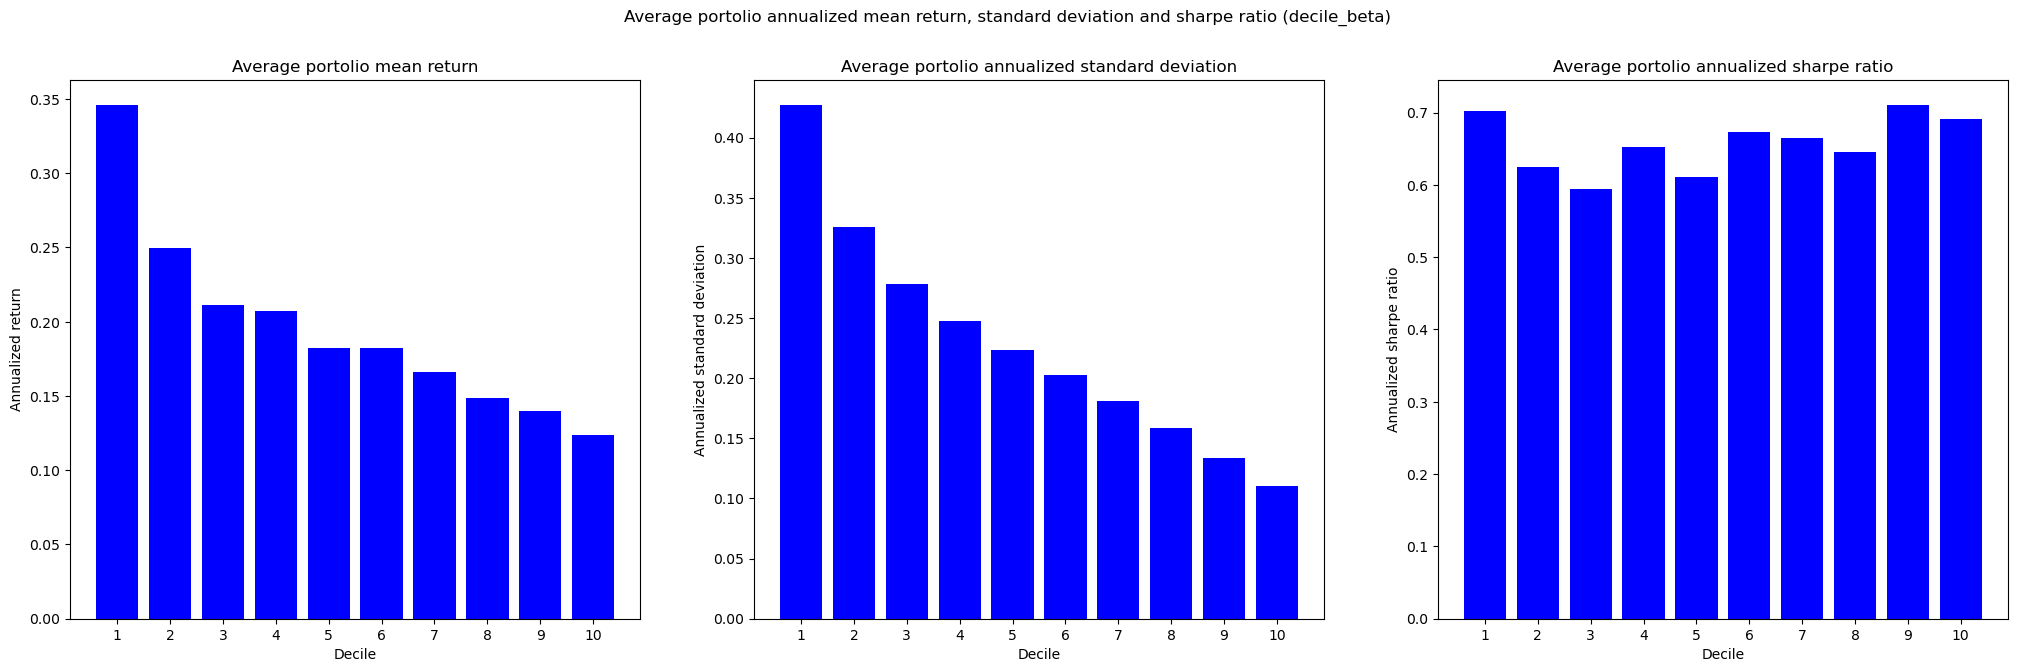

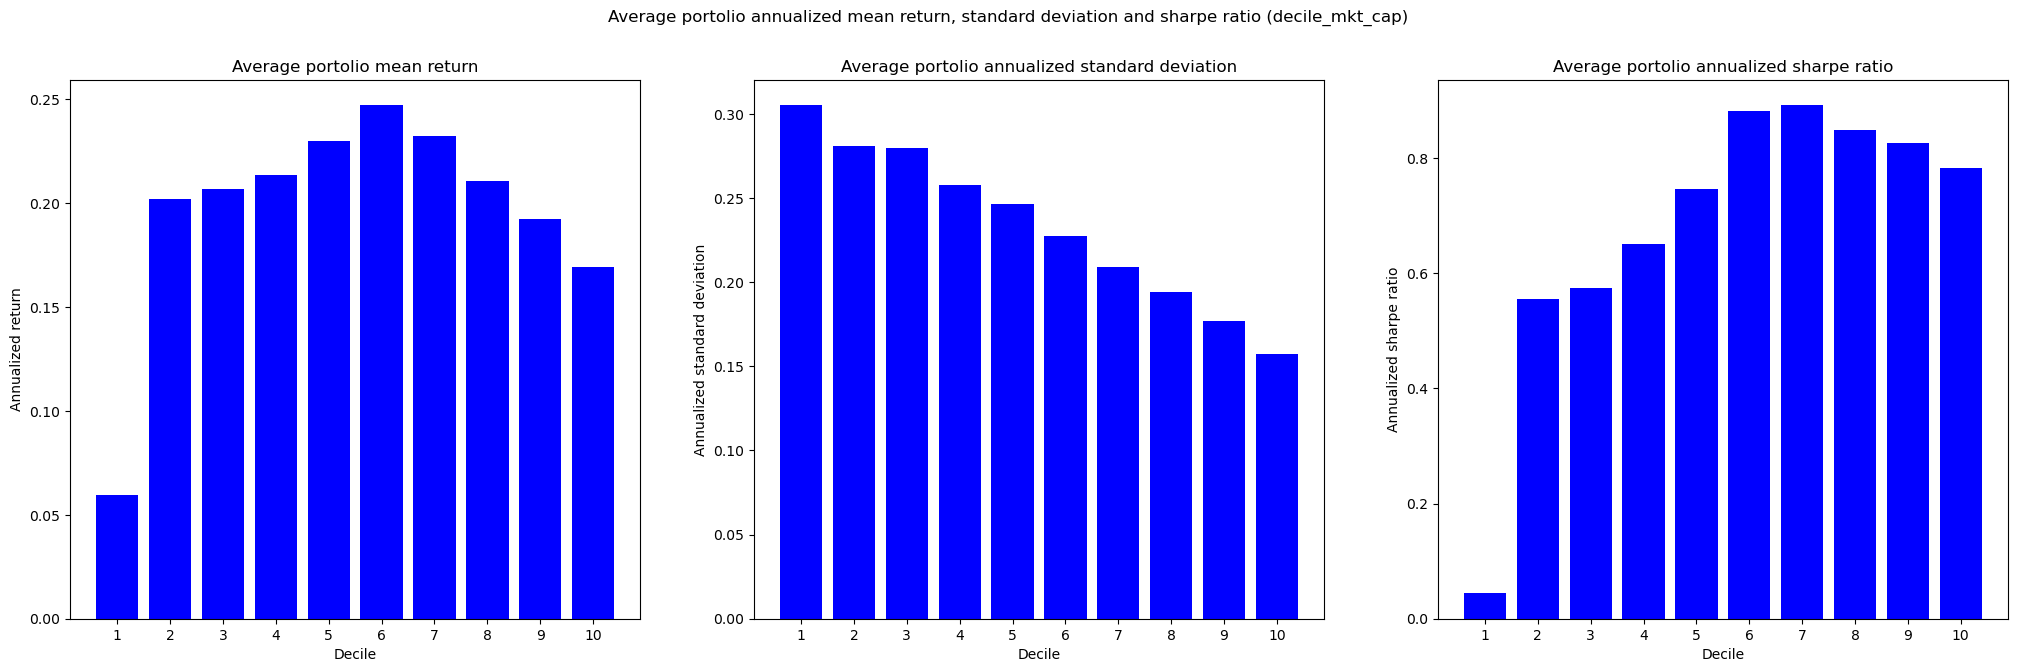

In [153]:
plot_return_std_SR_deciles(data_Qb, 'monthly_decile', 'monthly_return', 'decile_beta', '3b')
plot_return_std_SR_deciles(data_Qb, 'MktCap_decile', 'monthly_return_MktCap', 'decile_mkt_cap', '3b')

## Question c)

In [105]:
# Ensure 'date' is in datetime format
data_Qb['date'] = pd.to_datetime(data_Qb['date'])

# Step 1: Calculate the cross-sectional beta ranks for each date
data_Qb['beta_rank'] = data_Qb.groupby('date')['beta'].rank()

data_Qb

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,monthly_decile,monthly_return,MktCap,MktCap_decile,monthly_return_MktCap,beta_rank
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358,3,0.040807,6.607125e+03,0,-0.057235,532.0
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659,4,0.003701,8.089125e+03,0,0.029639,717.0
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189,4,0.040760,9.192188e+03,0,0.033312,773.0
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094,4,0.044687,1.093875e+04,0,0.009590,799.0
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478,5,0.017687,1.312650e+04,0,0.019988,993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402345,92655,2005-06-30,0.073281,1266160.0,52.1400,6324,0.002491,0.011529,0.009038,0.070790,1.079299,5,0.030368,6.601758e+07,9,0.016003,987.0
1402349,92655,2005-02-28,0.025422,653629.0,91.1600,6324,0.002083,0.022646,0.020563,0.023339,1.011342,5,0.023993,5.958482e+07,9,0.026099,966.0
1402350,92655,2005-01-31,0.009883,653629.0,88.9000,6324,0.001803,-0.026546,-0.028349,0.008080,1.011641,5,-0.016764,5.810762e+07,9,-0.019759,971.0
1402354,92655,2004-09-30,0.115076,664698.0,73.7400,6324,0.001216,0.020556,0.019340,0.113860,0.926645,4,0.048125,4.901483e+07,9,0.025386,856.0


In [ ]:
import pandas as pd
import numpy as np

# Assuming Data_beta is already loaded and includes 'beta' column
Data_beta = pd.read_csv('your_data_file.csv')  # Load your data file here

# Ensure 'date' is in datetime format
Data_beta['date'] = pd.to_datetime(Data_beta['date'])

# Step 1: Calculate the cross-sectional beta ranks for each date
Data_beta['beta_rank'] = Data_beta.groupby('date')['beta'].rank()

# Step 2: Compute the average rank for each date
Data_beta['average_rank'] = Data_beta.groupby('date')['beta_rank'].transform('mean')

# Step 3: Compute (z - z̄), (z - z̄)+, and (z - z̄)-
Data_beta['z_minus_z_bar'] = Data_beta['beta_rank'] - Data_beta['average_rank']
Data_beta['z_minus_z_bar_pos'] = Data_beta['z_minus_z_bar'].apply(lambda x: max(0, x))
Data_beta['z_minus_z_bar_neg'] = Data_beta['z_minus_z_bar'].apply(lambda x: min(0, x))

# Step 4: Compute the normalizing factor k = 2 and the absolute sum of z - z̄
Data_beta['abs_z_minus_z_bar'] = Data_beta['z_minus_z_bar'].abs()
abs_sum = Data_beta.groupby('date')['abs_z_minus_z_bar'].transform('sum')
k = 2

# Construct high-beta and low-beta portfolio weights
Data_beta['wH'] = k * Data_beta['z_minus_z_bar_pos'] / abs_sum
Data_beta['wL'] = k * Data_beta['z_minus_z_bar_neg'] / abs_sum

# Calculate portfolio returns for high-beta and low-beta portfolios
Data_beta['wH_ret'] = Data_beta['wH'] * Data_beta['ret']
Data_beta['wL_ret'] = Data_beta['wL'] * Data_beta['ret']

# Aggregate the portfolio returns by date
portfolio_returns = Data_beta.groupby('date').agg({'wH_ret': 'sum', 'wL_ret': 'sum'}).reset_index()

# Calculate the BAB factor return
portfolio_returns['BAB'] = portfolio_returns['wH_ret'] - portfolio_returns['wL_ret']

# Display the results
print(portfolio_returns.tail(5))


# 4 Momentum Strategy

## Question a)

In [110]:
display(data.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746


In [148]:
# Add a column for momentum return (last 12months, excluding last month)
# data.index = data[['date', 'permno']]
# data['date'] = pd.to_datetime(data['date'])
data.sort_values(by=['permno', 'date'], inplace=True)

display(data)
data_mom = data.copy()
data_mom.sort_values(['date'])
data_mom['roll_ret'] = data_mom.groupby('permno').ret.transform(lambda x: x.rolling(11, closed='left').sum())
display(data_mom)

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
94,10001,2009-12-31,0.162621,4361.0,10.3000,4925,0.000032,0.028475
93,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,0.000013,-0.037172
92,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.000061,0.034744
91,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.000112,0.063668
90,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.000118,0.020036
...,...,...,...,...,...,...,...,...
1438321,93426,2023-08-31,-0.037156,12581.0,36.0200,3676,0.004473,-0.020605
1438320,93426,2023-09-29,-0.067740,12581.0,33.5800,3676,0.004482,-0.047390
1438319,93426,2023-10-31,-0.108993,12581.0,29.9200,3676,0.004485,-0.028867
1438318,93426,2023-11-30,0.019051,12510.0,30.4900,3676,0.004465,0.092057


,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,roll_ret
94,10001,2009-12-31,0.162621,4361.0,10.3000,4925,0.000032,0.028475,NaN
93,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,0.000013,-0.037172,NaN
92,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.000061,0.034744,NaN
91,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.000112,0.063668,NaN
90,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.000118,0.020036,NaN
...,...,...,...,...,...,...,...,...,...
1438321,93426,2023-08-31,-0.037156,12581.0,36.0200,3676,0.004473,-0.020605,0.142511
1438320,93426,2023-09-29,-0.067740,12581.0,33.5800,3676,0.004482,-0.047390,0.242924
1438319,93426,2023-10-31,-0.108993,12581.0,29.9200,3676,0.004485,-0.028867,0.034596
1438318,93426,2023-11-30,0.019051,12510.0,30.4900,3676,0.004465,0.092057,-0.276471


In [149]:
# Create deciles for the momentum returns
data_mom['decile_mom'] = data_mom.groupby('date')['roll_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
display(data_mom.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,roll_ret,decile_mom
94,10001,2009-12-31,0.162621,4361.0,10.3000,4925,0.000032,0.028475,NaN,NaN
93,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,0.000013,-0.037172,NaN,NaN
92,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.000061,0.034744,NaN,NaN
91,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.000112,0.063668,NaN,NaN
90,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.000118,0.020036,NaN,NaN


,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,roll_ret,decile_mom,monthly_return_EW
485488,33144,1967-01-31,0.230769,582.0,4.00000,6149,0.003795,0.085530,0.127063,8.0,0.141078
1208761,78963,2003-03-31,0.106807,84898.0,20.00000,5621,0.000951,0.010321,0.144257,8.0,0.141546
1341522,87349,2005-03-31,-0.374648,61925.0,2.22000,4812,0.002168,-0.016944,-0.285335,0.0,-0.507995
1269207,82651,2013-02-28,0.012559,85887.0,92.72000,3826,0.000040,0.008282,0.032332,3.0,0.062495
1129847,75241,1998-08-31,-0.251429,100424.0,14.68750,1311,0.003917,-0.157860,-0.610439,0.0,-0.717704
1323427,86063,2005-02-28,-0.230769,41679.0,0.10000,7374,0.002083,0.022646,-0.911472,0.0,-0.500957
1406467,91207,2009-02-27,-0.233466,183005.0,11.59000,7011,0.000144,-0.100166,-0.944861,1.0,-1.013419
774392,48063,1990-11-30,-0.187500,12394.0,-0.40625,5271,0.005558,0.065742,-0.416725,3.0,-0.402735
37216,11415,2005-03-31,0.022832,102627.0,48.83000,2834,0.002168,-0.016944,0.105893,4.0,0.102834
874370,53268,1998-08-31,-0.061539,10743.0,3.81250,5013,0.003917,-0.157860,-0.296315,1.0,-0.332877


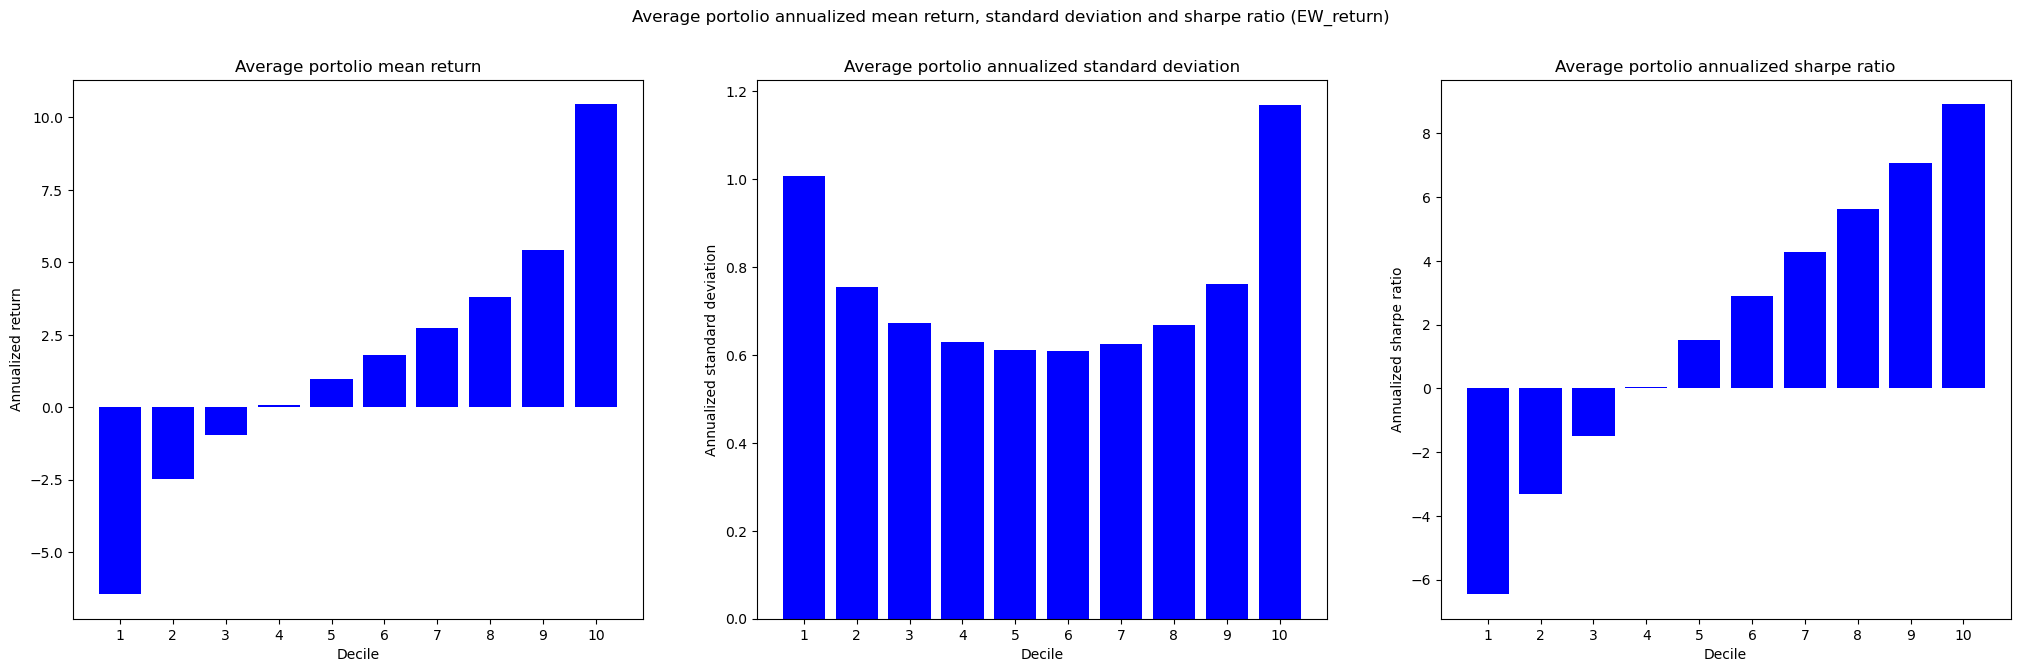

In [160]:
data_mom["monthly_return_EW"] = data_mom.groupby(["date", "decile_mom"])["roll_ret"].transform("mean")
data_mom.dropna(axis = 0, inplace=True)
display(data_mom.sample(60))

plot_return_std_SR_deciles(data_mom, 'decile_mom', 'monthly_return_EW', 'EW_return', '4a')